# Assessment of Operating Envelopes to Orchestrate DERs 
# OE Algorithm 4: Asset Capacity & Delta Voltage

## 1. Introduction

This work is part of the project [Assessing the Benefits of Using Operating Envelopes to Orchestrate DERs Across Australia](https://electrical.eng.unimelb.edu.au/power-energy/projects/assessing-the-benefits-of-OEs-across-Australia) funded by CSIRO. This project provided key metrics and recommendations for distribution companies (known as Distribution Network Service Providers [DNSPs] in Australia) and AEMO (the Australian system operator) to assist them in their decision-making process when defining the most suitable Operating Envelope (OE) implementations in a given distribution area.

> <span style="color:purple">**What are Operating Envelopes (OEs)?** OEs are time-varying export or import limits calculated in real time or in advance at the connection point of the customer to ensure the integrity of the distribution network (i.e., customer voltages within limits and no asset congestion). The OEs are calculated only for customers with flexible connection agreements (called here *active customers*). Customers with conventional connection agreements (called here *passive customers*) do not require OEs.</span>

**This interactive notebook demonstrates the process to implement the *Asset Capacity & Delta Voltage OE Algorithm*** produced by The University of Melbourne. This demonstration is useful for different stakeholders (e.g., DNSPs, AEMO, CSIRO, regulators, consultancy companies, technology providers) as it can help them familiarise with the corresponding algorithm and the required inputs as well as the pros and cons.

> <span style="color:purple">The **Asset Capacity & Delta Voltage (AC_∆V) OE** is more advanced than the AC_CrV OE, given that it can capture better the daily voltage variations due to interactions with the upstream HV network. Thermal aspects are considered by calculating the spare capacity of the distribution transformer, while voltage aspects are considered by estimating the voltage at the critical customer via two sensitivity curves, PDTx-VDTx sensitivity curve and PDTx-∆V sensitivity curve.</span>
> - Monitoring: At the secondary of the transformer (aggregated P, aggregated Q, and voltage magnitude, all per phase), and at the critical customer (voltage magnitude).
> - Electrical models needed: None.

## 2. Algorithm Overview
The **AC_∆V OE** has two requirements to calculate the OE. First, a PDTx-VDTx sensitivity curve (where PDTx is the active power on the distribution transformer, and VDTx is the voltage at the secondary side of the distribution transformer) is used to estimate the voltage magnitude at the distribution transformer (DTx) for a given estimated active power passing through the DTx. Second, a PDTx-∆V sensitivity curve is used to estimate the delta voltage between the DTx and the critical customer for a given estimated active power passing through the DTx. These sensitivity curves can be obtained beforehand with historical data, and they can be used for every time step since they are unlikely to change within short time periods. To obtain both sensitivity curves:

PDTx-VDTx Sensitivity Curve
1. Take the historical active power of the DTx for a given period (e.g., two days) and separate the time steps in which the LV network is exporting (or importing) power.
2. Separate the historical voltage magnitude of the DTx for when the LV network is exporting (or importing) power.
3. Use the separated data for voltage magnitude and aggregated active power of the DTx as input to a polynomial fit function from a standard library (e.g., Python NumPy) to create the PDTx-VDTx sensitivity curve for exports (or imports).

PDTx-∆V Sensitivity Curve
1. Take the historical active power of the DTx for a given period (e.g., two days) and separate the time steps in which the LV network is exporting (or importing) power.
2. Separate the historical voltage magnitude of the critical customer for when the LV network is exporting (or importing) power.
3. Use the separated data for voltage magnitude of the critical customer and active power of the DTx as input to a polynomial fit function from a standard library (e.g., Python NumPy) to create the PDTx-∆V sensitivity curve for exports (or imports).

<span style="color:red">**<u>Note</u>.</span>** The sensitivity curves for exports and imports are calculated separately.

Once the required sensitivity curves are available, the AC_∆V OE algorithm has two main steps. First, the spare capacity of the distribution transformer is split among active customers (temporary OE value). Second, both PDTx-VDTx and PDTx-∆V sensitivity curves are used to estimate the voltage at the critical customer for the estimated active power passing through the DTx (when considering the temporary OE value for all active customers). If the voltage is beyond the limit, the temporary OE value is reduced and the voltage re-estimated and re-assessed. This repeats until no voltage problem is expected. Furthermore, for calculations in advance (e.g., hours ahead), forecasting capabilities are also needed (however, here, perfect forecasting is used for simplicity).

For a given point in time (e.g., at 12:00PM), the high-level steps of the algorithm are as follows:
1. **Obtain forecasted aggregated passive customer net demand**. This value is obtained by subtracting the forecasted aggregated active customer net demand from the forecasted distribution transformer demand (which includes all customers).Note that sign convention and direction of power flows have to be adequately considered since one can be importing and the other exporting power depending on the time of the day.
2. **Calculate the spare capacity of the distribution transformer for OE exports (or OE imports)**. This value is obtained by subtracting the aggregated passive customer net demand forecast from the rated capacity of the transformer. It forms the basis to calculate OE exports (or OE imports). Note that sign convention and direction of power flows have to be adequately considered as the spare capacity will be different for exports and imports.
3. **Check if spare capacity is available for OE exports (or OE imports)**. If there is spare capacity available, proceed to step 4 to split the spare capacity. Otherwise, the calculated OE value to all active customers is equal to zero, thus proceed to step 10.
4. **Allocate the spare capacity for OE exports (or OE imports)**. Divide the spare capacity among all active customers, proportionally, considering the corresponding DER sizes. The allocated spare capacity to each active customer is a temporary export (or import) OE value (P'). 
5. **Estimate the active power at the distribution transformer (PDTx') for the temporary export (or import) OE value**. Use the temporary export (or import) OE value (P') to all active customers and the forecasted aggregated passive customer net demand to estimate the PDTx'.
6. **Estimate voltage at the distribution transformer (VDTx') for the temporary export (or import) OE value**. Use the estimated active power of the distribution transformer (PDTx') and the PDTx-VDTx sensitivity curve to estimate the VDTx'.
7. **Estimate the delta voltage (∆V') between the distribution transformer and the critical customer for the temporary export (or import) OE value**. Use the estimated active power of the distribution transformer (PDTx') and the PDTx-∆V sensitivity curve to estimate the ∆V'. 
8. **Estimate the voltage at the critical customer (V') for the temporary export (or import) OE value**. Sum the expected voltage at the distribution transformer (VDTx') to the expected delta voltage (∆V') to estimate V'.
9. **Check for voltage problems at the critical customer for the temporary export (or import) OE value**. If the estimated voltage at the critical customer (V') breaches the network limit, reduce the temporary OE value (P') by a pre-defined value (e.g., 1kW), and go back to step 5. Otherwise, the temporary OE value P' corresponds to the OE exports (or imports) for each active customer, thus proceed to step 10.
10. **Move to the next time step (e.g., 12:05PM) and restart the process from step 1.**

<span style="color:red">**<u>Note 1</u>.</span>** The OE exports and OE imports are calculated separately. When calculating exports, all active customers are considered to export. When calculating imports, all active customers are considered to import. This ensures the asset integrity even if all active customers operate at their maximum allocated OE capacity (worst case scenario).

<span style="color:red">**<u>Note 2</u>.</span>** The forecasted aggregated passive customer net demand in step 1 can also be obtained in other ways. For instance, if the DNSP has 100% smart meter penetration and forecast for all customers, the net demand of passive customers can be simply summed.

<span style="color:red">**<u>Note 3</u>.</span>** Network losses are not being considered here, but it should be simple to add to the algorithm.

<span style="color:red">**<u>Note 4</u>.</span>** For OE calculations in real-time no forecast is needed, real-time measurements from the network/customers should be used instead.

<span style="color:red">**<u>Note 5</u>.</span>** Only the proportional allocation can be done for the AC_CrV OE since other allocation techniques usually require knowledge of voltages in all customers.

<span style="color:red">**<u>Note 6</u>.</span>** The OE values are calculated for the active power only. The reactive power of PV systems are considered to be zero all the time.

<span style="color:red">**<u>Note 7</u>.</span>** The OE was not constrained by the LV head of feeder because it was considered the simplest possible algorithm to avoid needing extra data, but it can be easily added if data from individual LV feeders are available.

## 3. Inputs and Outputs for the OE Calculation Algorithm
### Time-Varying Inputs
- Historical voltage magnitude of the critical active customer in the LV network.
- Historical voltage magnitude at the secondary side of the distribution transformer.
- Historical active power at the distribution transformer.
- Forecasted aggregated active customer net demand (P).
- Forecasted distribution transformer demand (P, Q).

### Static Inputs
- Rated capacity of the distribution transformer.
- Number of active customers.
- DER size of active customers.

### Outputs
- The OEs for exports and imports. 

## 4. Test LV Network
To demonstrate the OE algorithm, the realistic Test LV network shown in Figure 1 is used. This network has the following characteristics:
- Three 3-phase LV feeders.
- 114 single-phase residential customers connected via service cables. 
- 16 (out of 114) are active customers (around 15%).
- 98 (out of 114) are passive customers.
- 35 of passive customers have PV systems (a PV penetration of 30% for the whole LV network).
- The PV systems have the same installed capacity of 5kVA. They also have the combined Volt-Watt and Volt-Var functions enabled.
- All active customers have the same DER installed capacity of 10kVA (e.g., PV + battery).

<span style="color:red">**<u>Note</u>.</span>** This interactive notebook is using a simple LV network model (without the HV part) for calculation of OEs and corresponding assessments, while the final report of the project is using the integrated HV-LV network model. To make the OEs calculated here closer to the ones in the report, the voltage variation along the day caused by the HV part is modelled here as a voltage source (following the measurements taken from the full HV-LV model). Despite this effort, the OE values calculated in the final report will still not be exactly the same as the ones calculated here. Nevertheless, the general qualitative nature of the OE is the same.

<img style="float: middle;" src="LV_Network.SVG" width="100%">  

**<center>Figure 1. Test LV Network</center>**   

## 5. Interactive Code
### 5.1. Initialisation of Libraries
 

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import dss


### 5.2. Load/Prepare Necessary Inputs
Load the necessary inputs to calculate the Asset Capacity & Delta Voltage OE.

In [2]:
# Load the list of active customers from the database
mydir = os.getcwd()
names_active_cust = np.load(mydir + '\\Simulation_Files\\active_cust_30-15.npy') 

# Assumed size of active customers' DERs is 10kW (PV + battery)
# In reality, this info would come from the database 
active_cust_der_size = np.ones(len(names_active_cust)) * 10 

# Known rated capaciy of the distribution transformer in kVA
# This info would come from the database
tx_rated_capacity = 500 

# Load the historical voltage magnitude of the critical active customer in the LV network
# NB. Critical customer chosen by its distance from the distirbution transformer
hist_voltage_crit_cust = np.load(mydir + '\\Simulation_Files\\AC_DeltaV_OE_V_crit_cust_30-15.npy') # 2 days of data

# Load the historical net active power demand of the distribution transformer
hist_agg_active_power_tx = np.load(mydir + '\\Simulation_Files\\AC_DeltaV_OE_P_tx_30-15.npy') # 2 days of data

# Load the historical voltage magnitude at the secondary side of the distribution transformer
hist_voltage_tx_sec = np.load(mydir + '\\Simulation_Files\\AC_DeltaV_OE_V_tx_30-15.npy') # 2 days of data

# load the forecasted aggregated active customer net demand
# sign convention: positive = exporting power; negative = importing power
forecast_agg_net_p_act_cust = np.load(mydir + '\\Simulation_Files\\ac_oe_agg_p_act_cust.npy') 

# load the forecasted distribution transformer active (P) and reactive (Q) power demand
# sign convention: positive = exporting power; negative = importing power
forecast_p_tx = np.load(mydir + '\\Simulation_Files\\ac_oe_p_tx.npy') # active power
forecast_q_tx = np.load(mydir + '\\Simulation_Files\\ac_oe_q_tx.npy') # reactive power

# Calculate the forecasted distribution transformer demand (apparent power, S)
forecast_s_tx = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    forecast_s_tx[i] = np.sqrt(forecast_p_tx[i]**2 + forecast_q_tx[i]**2)

# Calculate the forecasted aggregated passive customer net demand
# note that this calculation is not generalised and should be adapted for other data sets
forecast_agg_net_p_passive_cust = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    if forecast_p_tx[i] < 0 and forecast_agg_net_p_act_cust[i] < 0: 
        forecast_agg_net_p_passive_cust[i] = -1 * (forecast_s_tx[i] - abs(forecast_agg_net_p_act_cust[i]))
    if forecast_p_tx[i] > 0 and forecast_agg_net_p_act_cust[i] < 0: 
        forecast_agg_net_p_passive_cust[i] = forecast_s_tx[i] + abs(forecast_agg_net_p_act_cust[i])

# Calculate the spare capacity of the distribution transformer for exports     
forecast_spare_capacity_exp = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    if forecast_agg_net_p_passive_cust[i] < 0:
        forecast_spare_capacity_exp[i] = tx_rated_capacity + abs(forecast_agg_net_p_passive_cust[i])
    if forecast_agg_net_p_passive_cust[i] > 0:
        forecast_spare_capacity_exp[i] = tx_rated_capacity - abs(forecast_agg_net_p_passive_cust[i])

# Calculate the spare capacity of the distribution transformer for imports
forecast_spare_capacity_imp = np.zeros(len(forecast_p_tx))
for i in range(len(forecast_p_tx)):
    if forecast_agg_net_p_passive_cust[i] < 0:
        forecast_spare_capacity_imp[i] = tx_rated_capacity - abs(forecast_agg_net_p_passive_cust[i])
    if forecast_agg_net_p_passive_cust[i] > 0:
        forecast_spare_capacity_imp[i] = tx_rated_capacity + abs(forecast_agg_net_p_passive_cust[i])

### 5.3. Create Function for the Asset Capacity & Delta Voltage OE Algorithms
#### PDTx-VDTx Sensitivity Curve and PDTx-∆V Sensitivity Curve

In [3]:
# the historical data from the distirbution transformer and critical customer has to be processed before creating the
# PDTx-VDTx Sensitivity Curve

# initialise lists
p_agg_tx_exp = []
v_crit_cust_exp = []
v_tx_max_exp = []
v_tx_min_exp = []
p_agg_tx_imp = []
v_crit_cust_imp = []
v_tx_max_imp = []
v_tx_min_imp = []
delta_v_exp = []
delta_v_imp = []

#
for i in range((len(hist_voltage_tx_sec[0]))):
    if (hist_agg_active_power_tx[0][i]  > 0 and hist_agg_active_power_tx[1][i] > 0 and hist_agg_active_power_tx[2][i] > 0): 
        p_agg_tx_exp.append(hist_agg_active_power_tx[0][i] + hist_agg_active_power_tx[1][i] + hist_agg_active_power_tx[2][i])
        v_crit_cust_exp.append(hist_voltage_crit_cust[i])
        v_tx_max_exp.append(max(hist_voltage_tx_sec[0][i], hist_voltage_tx_sec[1][i], hist_voltage_tx_sec[2][i]))
        v_tx_min_exp.append(min(hist_voltage_tx_sec[0][i], hist_voltage_tx_sec[1][i], hist_voltage_tx_sec[2][i]))
    elif (hist_agg_active_power_tx[0][i] < 0 and hist_agg_active_power_tx[1][i] < 0 and hist_agg_active_power_tx[2][i] < 0): 
        p_agg_tx_imp.append((hist_agg_active_power_tx[0,i] + hist_agg_active_power_tx[1,i] + hist_agg_active_power_tx[2,i]))
        v_crit_cust_imp.append(hist_voltage_crit_cust[i])
        v_tx_max_imp.append(max(hist_voltage_tx_sec[0][i], hist_voltage_tx_sec[1][i], hist_voltage_tx_sec[2][i]))
        v_tx_min_imp.append(min(hist_voltage_tx_sec[0][i], hist_voltage_tx_sec[1][i], hist_voltage_tx_sec[2][i]))
        
# calculate ∆V for export
for i in range(len(v_crit_cust_exp)):
    delta_v_exp.append(v_crit_cust_exp[i] - v_tx_min_exp[i])

# calculate ∆V for import       
for i in range(len(v_crit_cust_imp)):
    delta_v_imp.append(v_crit_cust_imp[i] - v_tx_max_imp[i])
    
# Take the delta voltage and the distribution transformer aggregated active power and use a polynomial fit function from
# a standard library (e.g., Python NumPy) to create the PDtx-∆V sensitivity curve for export and import separately
pdtx_deltav_sensit_curve_exp = np.poly1d(np.polyfit(p_agg_tx_exp, delta_v_exp, 1)) # export
pdtx_deltav_sensit_curve_imp = np.poly1d(np.polyfit(p_agg_tx_imp, delta_v_imp, 1)) # import

# Take the voltage and the aggregated active power at the distribution transformer and use a polynomial fit function from
# a standard library (e.g., Python NumPy) to create the PDtx-VDtx sensitivity curve for export and import separately
pdtx_vdtx_sensit_curve_exp = np.poly1d(np.polyfit(p_agg_tx_exp, v_tx_max_exp, 1)) # export
pdtx_vdtx_sensit_curve_imp = np.poly1d(np.polyfit(p_agg_tx_imp, v_tx_min_imp, 1)) # import

Create a figures to show the PDTx-∆V sensitivty curves for export and import.

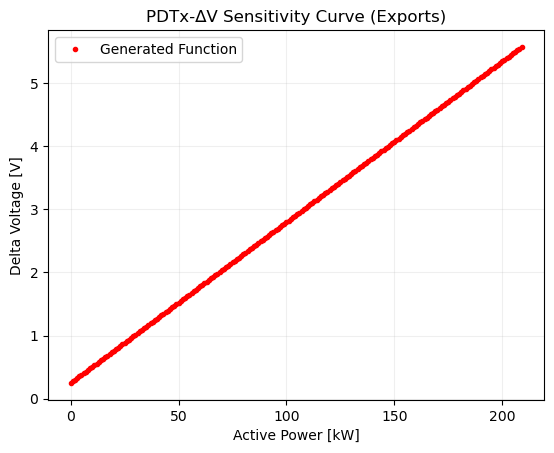

In [4]:
plt.figure()
p_tx_temp = range(210)
for i in range(len(p_tx_temp)):
    if i == 0:
        plt.plot(p_tx_temp[i], pdtx_deltav_sensit_curve_exp(p_tx_temp[i]), '.', color='red',  label='Generated Function')
    else:
        plt.plot(p_tx_temp[i], pdtx_deltav_sensit_curve_exp(p_tx_temp[i]), '.', color='red')
plt.title('PDTx-∆V Sensitivity Curve (Exports)')
plt.xlabel('Active Power [kW]')
plt.ylabel('Delta Voltage [V]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


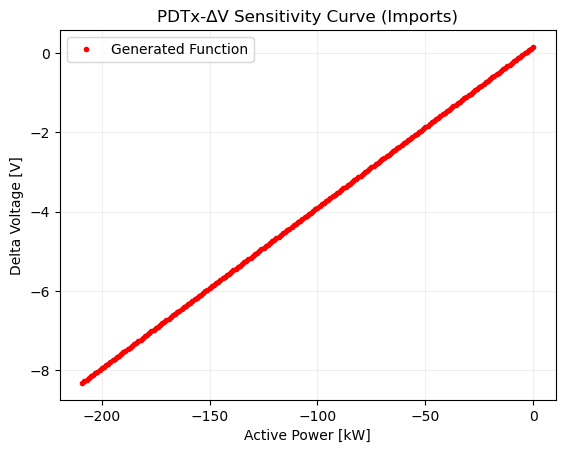

In [5]:
plt.figure()
p_tx_temp = range(0,-210,-1)
for i in range(len(p_tx_temp)):
    if i == 0:
        plt.plot(p_tx_temp[i], pdtx_deltav_sensit_curve_imp(p_tx_temp[i]), '.', color='red',  label='Generated Function')
    else:
        plt.plot(p_tx_temp[i], pdtx_deltav_sensit_curve_imp(p_tx_temp[i]), '.', color='red')
plt.title('PDTx-∆V Sensitivity Curve (Imports)')
plt.xlabel('Active Power [kW]')
plt.ylabel('Delta Voltage [V]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

Create a figures to show the PDTx-VDTx sensitivty curves for export and import.

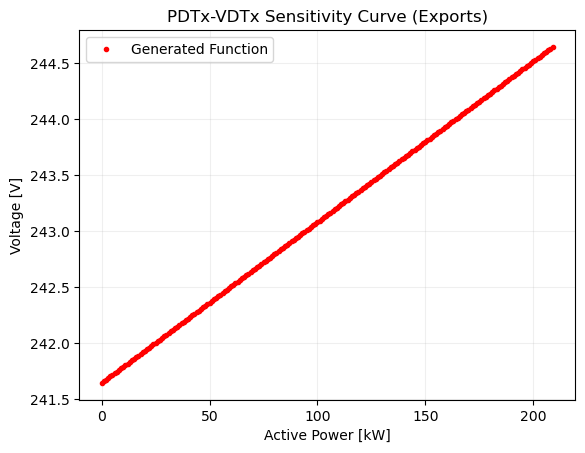

In [6]:
plt.figure()
p_tx_temp = range(210)
for i in range(len(p_tx_temp)):
    if i == 0:
        plt.plot(p_tx_temp[i], pdtx_vdtx_sensit_curve_exp(p_tx_temp[i]), '.', color='red',  label='Generated Function')
    else:
        plt.plot(p_tx_temp[i], pdtx_vdtx_sensit_curve_exp(p_tx_temp[i]), '.', color='red')
plt.title('PDTx-VDTx Sensitivity Curve (Exports)')
plt.xlabel('Active Power [kW]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

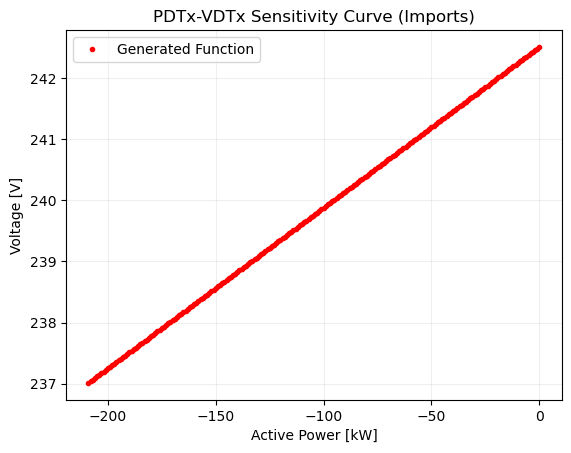

In [7]:
plt.figure()
p_tx_temp = range(0,-210,-1)
for i in range(len(p_tx_temp)):
    if i == 0:
        plt.plot(p_tx_temp[i], pdtx_vdtx_sensit_curve_imp(p_tx_temp[i]), '.', color='red',  label='Generated Function')
    else:
        plt.plot(p_tx_temp[i], pdtx_vdtx_sensit_curve_imp(p_tx_temp[i]), '.', color='red')
plt.title('PDTx-VDTx Sensitivity Curve (Imports)')
plt.xlabel('Active Power [kW]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

#### OEs for Exports

In [8]:
# function to calculate the AC_∆V OE for exports in each time step
# This is used in all time steps of the day
def ac_deltav_oe_exp_algorithm(
    names_active_cust, # this is the list of active customers
    tx_spare_capacity_exp, # this is the forecasted distribution transformer spare export capacity of the considered time step
    active_cust_der_size, # this is the size of active customers' DERs
    agg_net_p_passive_cust, # this is the forecasted aggregated passive customer net demand
    pdtx_deltav_sensit_curve_exp, # this is the PDTx-∆V sensitivity curve for exports
    pdtx_vdtx_sensit_curve_exp, # this is the PDTx-VDTx sensitivity curve for exports
):
    
    # First main step: the capacity of the distribution transformer together with its time-varying input data 
    # is used to calculate its spare capacity
    alloc_exp_p_temp = np.zeros(len(names_active_cust), float) # initialisation of the operating envelope value 
    
    # check if there is spare capacity on the distribution transformer, if positive there is spare capacity,
    # if negative or zero the allocated operating envelope is equal to zero (same value as initialisation)
    if tx_spare_capacity_exp > 0: 
        tx_spare_capacity_temp = tx_spare_capacity_exp # copy the spare capacity to a temporary variable
        
        # run this until there is no more spare capacity or the maximum possible OE value (defined by connection agreement,
        # or fuse of the house) was achieved to all active customers
        while tx_spare_capacity_temp > 0: 
            for ild in range(len(names_active_cust)): # iterate through all active customers to calculate the OE value
                
                # Proportionally allocate spare capacity of the distribution transformer to each active customer
                alloc_exp_p_temp[ild] += tx_spare_capacity_temp * active_cust_der_size[ild] / sum(active_cust_der_size) 
                
                # Check is the allocated spare capacity pass the maximum possible OE value and cap it if needed
                if alloc_exp_p_temp[ild] > 10:  # Usually maximum injection allowed by DNSPs per phase (10kW)
                    alloc_exp_p_temp[ild] = 10
            
            # check if the maximum possible OE value (10kW) was achieved to all active customers
            if (alloc_exp_p_temp == 10).all():
                break # the maximum possible OE value (10kW) was achieved to all active customers
            else:
                
                # there are still some active customers below the maximum possible OE value 
                # check if there is still some spare capacity to be allocated
                tx_spare_capacity_temp = tx_spare_capacity_exp - sum(alloc_exp_p_temp) 

                
        # Second main step: both PDTx-VDTx and PDTx-∆V sensitivity curves are used to estimate the voltage at the 
        # critical customer for a given aggregated active power passing through the DTx
        flag = 0 # flag to indicate when there is a voltage problem (0 = problems; 1 = no problems)
  
        # run the loop until no voltage problem is expected
        while flag == 0:
            
            # calculate the expected aggregated active power at the transformer
            # note that 12 is the location of the critical customer in the array
            expected_p_tx = agg_net_p_passive_cust + len(names_active_cust) * alloc_exp_p_temp[12] 
                        
            # use the PDTx-VDTx sensitivity curve to estimate the voltage at the transformer for the expected 
            # aggregated active power at the transformer
            expected_v_tx = pdtx_vdtx_sensit_curve_exp(expected_p_tx)
            
            # use the PDTx-∆V sensitivity curve to estimate the delta voltage between the critical customer and the 
            # distribution transformer for the expected aggregated active power at the transformer
            expected_delta_v = pdtx_deltav_sensit_curve_exp(expected_p_tx)
            
            # use the expected voltage at the distribution transformer and the expected delta voltage to calculate 
            # the expected voltage at the critical customer sensitivity curve to estimate the voltage at the critical customer
            expected_v_crit_cust = expected_v_tx + expected_delta_v
            
            # check if the expected voltage at the critical customer is above 253V  
            if expected_v_crit_cust > 253:
                alloc_exp_p_temp[12] -= 0.5 # if above the limit, reduce the allocated OE by 0.5kW (pre-defined reduction step)
                
                # check if the OE has achieved the minimum possible OE value (zero)
                if alloc_exp_p_temp[12] < 0: 
                    alloc_exp_p_temp[12] = 0 # if below zero, allocate zero as OE value
                    
                    # voltage problems are still expected even after OE value is equal to zero. OE calculation finished.
                    break
            else:
                flag = 1 # no voltage problems are expected. OE calculation finished.
    ac_deltav_oe_exp_values = alloc_exp_p_temp[12] # rename the allocated OE value
    
    return ac_deltav_oe_exp_values # return the calculated OE value for the export for the considered time step

#### OEs for Imports

In [9]:
# function to calculate the AC ∆V OE for imports in each time step
# This is used in all time steps of the day
def ac_deltav_oe_imp_algorithm(
    names_active_cust, # this is the list of active customers
    tx_spare_capacity_imp, # this is the distribution transformer spare import capacity of the considered time step
    active_cust_der_size, # this is the size of active customers' DERs
    agg_net_p_passive_cust, # this is the forecasted aggregated passive customer net demand
    pdtx_deltav_sensit_curve_imp, # this is the PDTx-∆V sensitivity curve for imports
    pdtx_vdtx_sensit_curve_imp, # this is the PDTx-VDTx sensitivity curve for imports

):
    
    # First main step: the capacity of the distribution transformer together with its time-varying input data 
    # is used to calculate its spare capacity
    alloc_imp_p_temp = np.zeros(len(names_active_cust), float) # initialisation of the operating envelope value 
    
    # check if there is spare capacity on the distribution transformer, if positive there is spare capacity,
    # if negative or zero the allocated operating envelope is equal to zero (same value as initialisation)
    if tx_spare_capacity_imp > 0: 
        tx_spare_capacity_temp = tx_spare_capacity_imp # copy the spare capacity to a temporary variable
        
        # run this until there is no more spare capacity or the maximum possible OE value (defined by connection agreement,
        # or fuse of the house) was achieved to all active customers
        while tx_spare_capacity_temp > 0:
            for ild in range(len(names_active_cust)): # iterate through all active customers to calculate the OE value
                
                # Proportionally allocate spare capacity of the distribution transformer to each active customer
                alloc_imp_p_temp[ild] += tx_spare_capacity_temp * active_cust_der_size[ild] / sum(active_cust_der_size) # Proportionally allocate spare capacity of the distribution transformer to active customers (power factor equal to 1)
                
                # Check is the allocated spare capacity pass the maximum possible OE value and cap it if needed
                if alloc_imp_p_temp[ild] > 14: # Limited by a single-phase fuse of 60A (14kW)
                    alloc_imp_p_temp[ild] = 14 
            
            # check if the maximum possible OE value (14kW) was achieved to all active customers
            if (alloc_imp_p_temp == 14).all():
                break # the maximum possible OE value (14kW) was achieved to all active customers
            else:
                
                # there are still some active customers below the maximum possible OE value 
                # check if there is still some spare capacity to be allocated
                tx_spare_capacity_temp = tx_spare_capacity_imp - sum(alloc_imp_p_temp)
        
        
        # Second main step: the P-V sensitivity curve for the critical customer is used to estimate its voltage
        flag = 0 # flag to indicate when there is a voltage problem (0 = problems; 1 = no problems)
        
        # run the loop until no voltage problem is expected
        while flag == 0:

            
            # calculate the expected aggregated active power at the transformer
            # note that 12 is the location of the critical customer in the array
            expected_p_tx = agg_net_p_passive_cust + len(names_active_cust) * -1 * alloc_imp_p_temp[12]             
            
            # use the PDTx-VDTx sensitivity curve to estimate the voltage at the transformer for the expected 
            # aggregated active power at the transformer
            expected_v_tx = pdtx_vdtx_sensit_curve_imp(expected_p_tx)
            
            # use the PDTx-∆V sensitivity curve to estimate the delta voltage between the critical customer and the 
            # distribution transformer for the expected aggregated active power at the transformer
            expected_delta_v = pdtx_deltav_sensit_curve_imp(expected_p_tx)
            
            # use the expected voltage at the distribution transformer and the expected delta voltage to calculate 
            # the expected voltage at the critical customer sensitivity curve to estimate the voltage at the critical customer
            expected_v_crit_cust = expected_v_tx + expected_delta_v            
            
            # check if the expected voltage at the critical customer is below 216V  
            if expected_v_crit_cust < 216:
                
                # if above the limit, reduce the allocated OE by 0.5kW (pre-defined reduction step)
                # since the "expected_pnet_crit_cust" is negative the 0.5kW is summed to it
                alloc_imp_p_temp[12] -= 0.5 
                
                # check if the OE has achieved the minimum possible OE value (zero)
                if alloc_imp_p_temp[12] > 0: 
                    alloc_imp_p_temp[12] = 0 # if below zero, allocate zero as OE value
                    
                    # voltage problems are still expected even after OE value is equal to zero. OE calculation finished.
                    break 
            else:
                flag = 1 # no voltage problems are expected, so OE calculation finished    
    ac_deltav_oe_imp_values = alloc_imp_p_temp[12] # rename the allocated OE value
    
    return ac_deltav_oe_imp_values # return the calculated OE value for the import for the considered time step

### 5.4. Run the Asset Capacity OE Algorithm for the Day

In [10]:
# define time resolution of the data
Time_Resolution = 5 # in minutes

# define number of time steps in the day (24h) for the corresponding time resolution
Num_of_TimeStep = 288

# initialise arrays to save the OE values for each time step of the day
ac_deltav_oe_day_exp_values = np.zeros((len(names_active_cust), Num_of_TimeStep), float) # for exports
ac_deltav_oe_day_imp_values = np.zeros((len(names_active_cust), Num_of_TimeStep), float) # for imports

# Calculate the OE values for each time step of the day in a for loop
for iTime in range(Num_of_TimeStep):
    tx_spare_capacity_exp = forecast_spare_capacity_exp[iTime] # separate the transformer export capacity for the current time step
    tx_spare_capacity_imp = forecast_spare_capacity_imp[iTime] # separate the transformer import capacity for the current time step
    agg_net_p_passive_cust = forecast_agg_net_p_passive_cust[iTime] # separate the transformer import capacity for the current time step
    
    # call the AC CrV OE functions to calculate the OE value to each time step
    ac_deltav_oe_day_exp_values[:,iTime] = ac_deltav_oe_exp_algorithm(names_active_cust, tx_spare_capacity_exp, active_cust_der_size, agg_net_p_passive_cust, pdtx_deltav_sensit_curve_exp, pdtx_vdtx_sensit_curve_exp) # export
    ac_deltav_oe_day_imp_values[:,iTime] = ac_deltav_oe_imp_algorithm(names_active_cust, tx_spare_capacity_imp, active_cust_der_size, agg_net_p_passive_cust, pdtx_deltav_sensit_curve_imp, pdtx_vdtx_sensit_curve_imp) # import

Create a figure to show the calculated OE values (exports/imports) for the entire day.

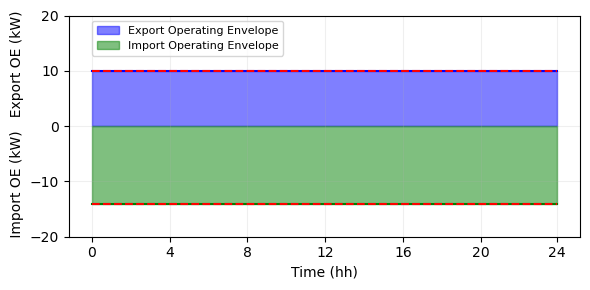

In [11]:
# plot the calculated oeprating envelopes
x = range(Num_of_TimeStep)
y1 = ac_deltav_oe_day_exp_values
y2 = ac_deltav_oe_day_imp_values * -1
y3 = np.ones(Num_of_TimeStep) * 10
y4 = np.ones(Num_of_TimeStep) * -14

plt.figure(figsize=(6,3))
ax = plt.axes()
plt.ylabel(" Import OE (kW)   Export OE (kW)")
plt.xlabel("Time (hh)")
plt.fill_between(x, y1[12], color="blue", alpha=0.5, label='Export Operating Envelope')
plt.plot(x, y1[12], color="blue", alpha=1)
plt.fill_between(x, y2[12], color="green", alpha=0.5, label='Import Operating Envelope')
plt.plot(x, y2[12], color="green", alpha=1)
plt.plot(x, y3, color="red", linestyle='dashed', alpha=1)
plt.plot(x, y4, color="red", linestyle='dashed', alpha=1)
ax.set_xticks([0, 48, 96, 144, 192, 240, 287])
ax.set_xticklabels([0, 4, 8, 12, 16, 20, 24])
plt.grid(alpha=0.2)
plt.ylim(-20, 20)
plt.legend(loc='upper right', fontsize=8, bbox_to_anchor=(0, 0, 0.43, 1))
plt.tight_layout()
plt.show()


Given that all active customers have the same DER installed capacity (10kVA), the calculated OEs (shown in the figure above) is the same for all active customers. It is important to note that:
- Because this OE algorithm underestimate voltages at the critical customer, the OE values were not constrained.
- The OEs for exports reached 10kW as it corresponds to the maximum possible exports (due to the installed DER).
- The OEs for imports reached 14kW as it corresponds to the maximum possible imports (considering a 60A fuse for a single-phase customer and to allow for local demand).

### 5.5. Perfomance Check
Now the efficacy of the calculated OEs is checked using the Test LV Networks.

<span style="color:red">**<u>Note</u>.</span>** All active customers are assumed to be using the full available OE value calculated for them.

In [12]:
# initialise the OpenDSS to run the network
dss_engine = dss.DSS
DSSText = dss_engine.Text                                                      
DSSCircuit = dss_engine.ActiveCircuit                                            
DSSSolution = dss_engine.ActiveCircuit.Solution                                      
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue                                          
dss_engine.AllowForms = 0

# load the entire LV network with transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation
DSSText.Command = 'Clear'
DSSText.Command = 'Compile ' + mydir + '\\Simulation_Files\\Master.txt' 
DSSText.Command = 'Set VoltageBases=[22.0, 0.400, 0.2309]'
DSSText.Command = 'calcv'
DSSText.Command = 'Set ControlMode=static'
DSSText.Command = 'Reset'                                                     
DSSText.Command = 'Set Mode=daily number=1 stepsize='+str(Time_Resolution)+'m' 

# load voltage magnitudes and angles at the primary side of the distribution transformer which are affected by the 
# interactions with the upstream HV network (collected in another platform where the HV-LV network is fully modelled)
tx_pri_voltages_day_exp = np.load(mydir + '\\Simulation_Files\\ac_deltav_tx_pri_voltages_day_exp_30-15.npy') # voltage magnitudes during exports
tx_pri_angles_day_exp = np.load(mydir + '\\Simulation_Files\\ac_deltav_tx_pri_angles_day_exp_30-15.npy') # voltage angles during exports
tx_pri_voltages_day_imp = np.load(mydir + '\\Simulation_Files\\ac_deltav_tx_pri_voltages_day_imp_30-15.npy') # voltage magnitudes during imports
tx_pri_angles_day_imp = np.load(mydir + '\\Simulation_Files\\ac_deltav_tx_pri_angles_day_imp_30-15.npy') # voltage angles during imports

# load LV network data from the OpenDSS model
load_list = DSSCircuit.Loads.AllNames # list of loads
line_list = DSSCircuit.Lines.AllNames # list of lines

# initialisation of arrays/lists to save simulation data
valid_exp_voltage_lv_cust = np.zeros((len(load_list), Num_of_TimeStep), float)
valid_imp_voltage_lv_cust = np.zeros((len(load_list), Num_of_TimeStep), float)
valid_exp_max_lv_hof_util  = []
valid_imp_max_lv_hof_util  = []
valid_exp_lv_tx_util  = []
valid_imp_lv_tx_util  = []



# Test for OE Export
# implement the calculated OE value or each time step of the day in a for loop and check for technical compliance
for iTime in range(Num_of_TimeStep):
    # Set vsource with the distribution transformer voltage magnitudes and angles for the time step at the primary side
    temp1 = tx_pri_voltages_day_exp[0][iTime] / (22000 / np.sqrt(3))
    temp2 = tx_pri_angles_day_exp[0][iTime]
    temp3 = tx_pri_voltages_day_exp[1][iTime] / (22000 / np.sqrt(3))
    temp4 = tx_pri_angles_day_exp[1][iTime]
    temp5 = tx_pri_voltages_day_exp[2][iTime] / (22000 / np.sqrt(3))
    temp6 = tx_pri_angles_day_exp[2][iTime]
    DSSText.Command = 'edit vsource.source bus1=sourcebus.1 basekv=12.701706 pu='+str(temp1)+' angle='+str(temp2)+' phases=1'
    DSSText.Command = 'edit vsource.source2 bus1=sourcebus.2 basekv=12.701706 pu='+str(temp3)+' angle='+str(temp4)+' phases=1'    
    DSSText.Command = 'edit vsource.source3 bus1=sourcebus.3 basekv=12.701706 pu='+str(temp5)+' angle='+str(temp6)+' phases=1'    
    
    
    DSSCircuit.Solution.Solve()
 
    
    # implement the calculated OE value to each active customer
    for ild in range(len(names_active_cust)):
        DSSCircuit.SetActiveElement('load.' + str(names_active_cust[ild])) # select an active customer
        temp = DSSCircuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
        DSSCircuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
        DSSCircuit.ActiveElement.Properties('kw').Val = str(-1 * ac_deltav_oe_day_exp_values[ild, iTime]) # set the kW to the calculated OE value
        DSSCircuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before    
    
    DSSSolution.SolveSnap() # solve the power flow for the time step with OE values in place

    # verify thermal limits of lines
    for iLine in range(len(line_list)):
        DSSCircuit.SetActiveElement('line.' + str(line_list[iLine])) # select a line
        I11 = DSSCircuit.ActiveCktElement.CurrentsMagAng[0] # extract the current at the corresponding line (phase A)
        I12 = DSSCircuit.ActiveCktElement.CurrentsMagAng[2] # extract the current at the corresponding line (phase B)
        I13 = DSSCircuit.ActiveCktElement.CurrentsMagAng[4] # extract the current at the corresponding line (phase C)
        I_rated = DSSCircuit.Lines.NormAmps # extract rated capacity of the corresponding line
        I_max_temp = max(I11, I12, I13) # find the maximum current among the three phases
        if line_list[iLine] == 'hv_f0_lv28_f0_l0':
            lv_hof_util_f0 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 1, calculate the utilisation
        if line_list[iLine] == 'hv_f0_lv28_f1_l0':
            lv_hof_util_f1 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 2, calculate the utilisation
        if line_list[iLine] == 'hv_f0_lv28_f2_l0':
            lv_hof_util_f2 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 3, calculate the utilisation
    lv_hof_util_max = max(lv_hof_util_f0, lv_hof_util_f1, lv_hof_util_f2) # find the maximum utilisation at the HoF
    
    # verify thermal limits of transformer
    DSSCircuit.SetActiveElement('transformer.hv_f0_lv28_tx') # select the distribution transformer
    DSSCircuit.Transformers.Wdg = 2 # select secondary winding (LV side)
    tx_rated_volt_sec = DSSCircuit.Transformers.kV / np.sqrt(3) # Extract the transformer rated voltage at the secondary side
    tx_amp_capacity_phase = (float(DSSCircuit.ActiveCktElement.Properties('kVAs').Val.strip('[').strip(']').split(',')[0]) / 3) / tx_rated_volt_sec # extract the capacity in amps per phase
    I1_LVT_temp = DSSCircuit.ActiveCktElement.CurrentsMagAng[8] # extract the current at the corresponding transformer (phase A)
    I2_LVT_temp = DSSCircuit.ActiveCktElement.CurrentsMagAng[10] # extract the current at the corresponding transformer (phase B)
    I3_LVT_temp = DSSCircuit.ActiveCktElement.CurrentsMagAng[12] # extract the current at the corresponding transformer (phase C)
    lv_tx_util = 100 * (I1_LVT_temp + I2_LVT_temp + I3_LVT_temp) / (3 * tx_amp_capacity_phase) # find the maximum utilisation at the transformer
        
    # verify voltages in all customers
    all_volt_temp = [] # initialise array to collect the voltages
    for ild in range(len(load_list)):
        DSSCircuit.SetActiveElement('load.' + str(load_list[ild])) # select the customer
        temp = DSSCircuit.ActiveElement.VoltagesMagAng # extract the voltage magnitude
        all_volt_temp.append(temp[0]) # add the voltage to the array 
            
    valid_exp_voltage_lv_cust[:, iTime] = all_volt_temp # save voltages from all customers for the current time step 
    valid_exp_max_lv_hof_util.append(lv_hof_util_max) # save the maximum utilisation of the LV HoF for the current time step
    valid_exp_lv_tx_util.append(lv_tx_util) # save the transformer utilisation for the current time step


    # Reset active customers to original profile values for the next time step
    default_kw_kvar = 1
    for ild in range(len(names_active_cust)):
        DSSCircuit.SetActiveElement('load.' + str(names_active_cust[ild]))
        DSSCircuit.ActiveElement.Properties('status').Val = 'variable'
        DSSCircuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
        DSSCircuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)        
    
    
    
# Test for OE Import
# re-load the entire LV network with transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation
DSSText.Command = 'Clear'
DSSText.Command = 'Compile ' + mydir + '\\Simulation_Files\\Master.txt' 
DSSText.Command = 'Set VoltageBases=[22.0, 0.400, 0.2309]'
DSSText.Command = 'calcv'
DSSText.Command = 'Set ControlMode=static'
DSSText.Command = 'Reset'                                                     
DSSText.Command = 'Set Mode=daily number=1 stepsize='+str(Time_Resolution)+'m' 

# implement the calculated OE value or each time step of the day in a for loop and check for technical compliance
for iTime in range(Num_of_TimeStep):
    # Set vsource with the distribution transformer voltage magnitudes and angles for the time step at the primary side
    temp1 = tx_pri_voltages_day_imp[0][iTime] / (22000 / np.sqrt(3))
    temp2 = tx_pri_angles_day_imp[0][iTime]
    temp3 = tx_pri_voltages_day_imp[1][iTime] / (22000 / np.sqrt(3))
    temp4 = tx_pri_angles_day_imp[1][iTime]
    temp5 = tx_pri_voltages_day_imp[2][iTime] / (22000 / np.sqrt(3))
    temp6 = tx_pri_angles_day_imp[2][iTime]
    DSSText.Command = 'edit vsource.source bus1=sourcebus.1 basekv=12.701706 pu='+str(temp1)+' angle='+str(temp2)+' phases=1'
    DSSText.Command = 'edit vsource.source2 bus1=sourcebus.2 basekv=12.701706 pu='+str(temp3)+' angle='+str(temp4)+' phases=1'    
    DSSText.Command = 'edit vsource.source3 bus1=sourcebus.3 basekv=12.701706 pu='+str(temp5)+' angle='+str(temp6)+' phases=1'    
    
    
    DSSCircuit.Solution.Solve()    
    
    
    # implement the calculated OE value to each active customer 
    for ild in range(len(names_active_cust)):
        DSSCircuit.SetActiveElement('load.' + str(names_active_cust[ild])) # select an active customer
        temp = DSSCircuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
        DSSCircuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
        DSSCircuit.ActiveElement.Properties('kw').Val = str(ac_deltav_oe_day_imp_values[ild, iTime]) # set the kW to the calculated OE value
        DSSCircuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before    
        
    DSSSolution.SolveSnap() # solve the power flow for the time step with OE values in place

    # verify thermal limits of lines
    for iLine in range(len(line_list)):
        DSSCircuit.SetActiveElement('line.' + str(line_list[iLine])) # select a line
        I11 = DSSCircuit.ActiveCktElement.CurrentsMagAng[0] # extract the current at the corresponding line (phase A)
        I12 = DSSCircuit.ActiveCktElement.CurrentsMagAng[2] # extract the current at the corresponding line (phase B)
        I13 = DSSCircuit.ActiveCktElement.CurrentsMagAng[4] # extract the current at the corresponding line (phase c)
        I_rated = DSSCircuit.Lines.NormAmps # extract rated capacity of the corresponding line
        I_max_temp = max(I11, I12, I13) # find the maximum current among the three phases
        if line_list[iLine] == 'hv_f0_lv28_f0_l0':
            lv_hof_util_f0 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 1, calculate the utilisation
        if line_list[iLine] == 'hv_f0_lv28_f1_l0':
            lv_hof_util_f1 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 2, calculate the utilisation
        if line_list[iLine] == 'hv_f0_lv28_f2_l0':
            lv_hof_util_f2 = 100 * I_max_temp / I_rated # if it is the LV head of feeder 3, calculate the utilisation
    lv_hof_util_max = max(lv_hof_util_f0, lv_hof_util_f1, lv_hof_util_f2) # find the maximum utilisation at the HoF
    
    # verify thermal limits of transformer
    DSSCircuit.SetActiveElement('transformer.hv_f0_lv28_tx') # select the distribution transformer
    DSSCircuit.Transformers.Wdg = 2 # select secondary winding (LV side)
    tx_rated_volt_sec = DSSCircuit.Transformers.kV / np.sqrt(3) # Extract the transformer rated voltage at the secondary side
    tx_amp_capacity_phase = (float(DSSCircuit.ActiveCktElement.Properties('kVAs').Val.strip('[').strip(']').split(',')[0]) / 3) / tx_rated_volt_sec # extract the capacity in amps per phase
    I1_LVT_temp = DSSCircuit.ActiveCktElement.CurrentsMagAng[8] # extract the current at the corresponding transformer (phase A)
    I2_LVT_temp = DSSCircuit.ActiveCktElement.CurrentsMagAng[10] # extract the current at the corresponding transformer (phase B)
    I3_LVT_temp = DSSCircuit.ActiveCktElement.CurrentsMagAng[12] # extract the current at the corresponding transformer (phase C)
    lv_tx_util = 100 * (I1_LVT_temp + I2_LVT_temp + I3_LVT_temp) / (3 * tx_amp_capacity_phase) # find the maximum utilisation at the transformer
        
    # verify voltages in all customers
    all_volt_temp = [] # initialise array to collect the voltages
    for ild in range(len(load_list)):
        DSSCircuit.SetActiveElement('load.' + str(load_list[ild])) # select the customer
        temp = DSSCircuit.ActiveElement.VoltagesMagAng # extract the voltage magnitude
        all_volt_temp.append(temp[0]) # add the voltage to the array 
     
    valid_imp_voltage_lv_cust[:, iTime] = all_volt_temp # save voltages from all customers for the current time step 
    valid_imp_max_lv_hof_util.append(lv_hof_util_max) # save the maximum utilisation of the LV HoF for the current time step
    valid_imp_lv_tx_util.append(lv_tx_util) # save the transformer utilisation for the current time step
    
    
    # Reset active customers to original profile values for the next time step
    default_kw_kvar = 1
    for ild in range(len(names_active_cust)):
        DSSCircuit.SetActiveElement('load.' + str(names_active_cust[ild]))
        DSSCircuit.ActiveElement.Properties('status').Val = 'variable'
        DSSCircuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
        DSSCircuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)    
    
    
    
# Check network-wide voltage compliance
valid_exp_voltage_lv_cust_10min = np.zeros((len(load_list), 144), float)
valid_imp_voltage_lv_cust_10min = np.zeros((len(load_list), 144), float)
valid_exp_voltage_lv_cust_10min_sorted = np.zeros((len(load_list), 144), float)
valid_imp_voltage_lv_cust_10min_sorted = np.zeros((len(load_list), 144), float)
cont_exp = 0
cont_imp = 0
for ild in range(len(load_list)):
    for i in range(144):
        valid_exp_voltage_lv_cust_10min[ild,i] = (valid_exp_voltage_lv_cust[ild,2*i] + valid_exp_voltage_lv_cust[ild,2*i+1]) / 2
        valid_imp_voltage_lv_cust_10min[ild,i] = (valid_imp_voltage_lv_cust[ild,2*i] + valid_imp_voltage_lv_cust[ild,2*i+1]) / 2
    valid_exp_voltage_lv_cust_10min_sorted[ild,:] = np.sort(valid_exp_voltage_lv_cust_10min[ild,:])
    valid_imp_voltage_lv_cust_10min_sorted[ild,:] = np.sort(valid_imp_voltage_lv_cust_10min[ild,:])

    if (valid_exp_voltage_lv_cust_10min_sorted[ild,142] > 253) or (valid_exp_voltage_lv_cust_10min_sorted[ild,1] < 216):
        cont_exp += 1
    if (valid_imp_voltage_lv_cust_10min_sorted[ild,1] < 216) or (valid_imp_voltage_lv_cust_10min_sorted[ild,142] > 253):
        cont_imp += 1

exp_voltage_compliance = (1 - ((cont_exp) / len(load_list))) * 100
imp_voltage_compliance = (1 - ((cont_imp) / len(load_list))) * 100   

Present various metrics showing the performance of the calculated OE export values for the considered day.


 EXPORTS

 The maximum voltage at customers: 256.0450304545953 V (Between the maximum voltage limit of 253V and the inverter tripping value of 258V)

 The network-wide voltage compliance: 95.6140350877193 % (Above the recommmended value of 95%)

 The maximum utilisation of the distribution transformer: 53.85275028838046 % (Below the maximum utilisation of 100%)

 The maximum utilisation of the LV Head of Feeder: 58.644437039990514 % (Below the maximum utilisation of 100%)


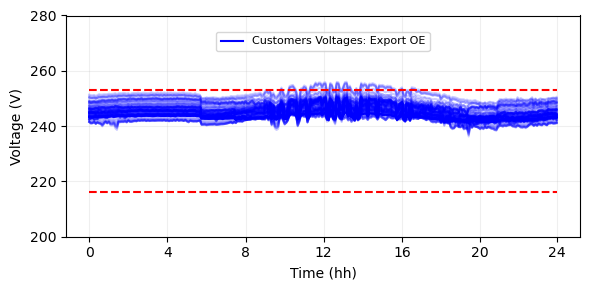

In [13]:
print('\n EXPORTS')
print('\n The maximum voltage at customers: {} V (Between the maximum voltage limit of 253V and the inverter tripping value of 258V)'.format(np.max(valid_exp_voltage_lv_cust)))
print('\n The network-wide voltage compliance: {} % (Above the recommmended value of 95%)'.format(exp_voltage_compliance))
print('\n The maximum utilisation of the distribution transformer: {} % (Below the maximum utilisation of 100%)'.format(np.max(valid_exp_lv_tx_util)))
print('\n The maximum utilisation of the LV Head of Feeder: {} % (Below the maximum utilisation of 100%)'.format(np.max(valid_exp_max_lv_hof_util)))

# plot the voltage at all customers
x = range(Num_of_TimeStep)
y1 = valid_exp_voltage_lv_cust
y2 = np.ones(Num_of_TimeStep) * 216
y3 = np.ones(Num_of_TimeStep) * 253

plt.figure(figsize=(6,3))
ax = plt.axes()
plt.ylabel("Voltage (V)")
plt.xlabel("Time (hh)")
for ild in range(len(load_list)):
    if ild == 0:
        plt.plot(x, y1[ild,:], color="blue", alpha=1, label="Customers Voltages: Export OE")
    else:
        plt.plot(x, y1[ild,:], color="blue", alpha=0.2)
plt.plot(x, y2, color="red", linestyle='dashed', alpha=1)
plt.plot(x, y3, color="red", linestyle='dashed', alpha=1)
ax.set_xticks([0, 48, 96, 144, 192, 240, 287])
ax.set_xticklabels([0, 4, 8, 12, 16, 20, 24])
plt.grid(alpha=0.2)
plt.ylim(200, 280)
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.815, 0, 0))
plt.tight_layout()
plt.show()

Present various metrics showing the performance of the calculated OE import values for the considered day.


 IMPORTS

 The minimum voltage at customers: 220.1891152591675 V (Above the minimum voltage limit of 216V)

 The network-wide voltage compliance: 100.0 % (Above the recommmended value of 95%)

 The maximum utilisation of the distribution transformer: 61.845294376357266 % (Below the maximum utilisation of 100%)

 The maximum utilisation of the LV Head of Feeder: 106.80929781809141 % (Above the maximum utilisation of 100%, but below the acceptable overload of 110%. Note that this happens because the LV head of feeder was not considered in the algorithm design as previously explained)


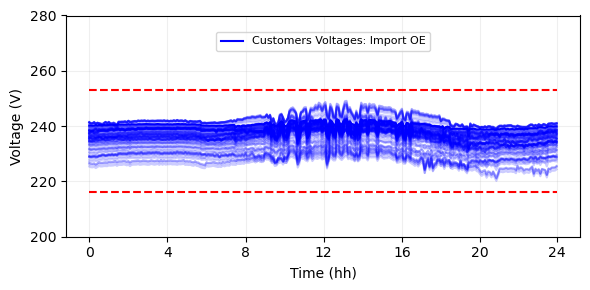

In [14]:
print('\n IMPORTS')
print('\n The minimum voltage at customers: {} V (Above the minimum voltage limit of 216V)'.format(np.min(valid_imp_voltage_lv_cust)))
print('\n The network-wide voltage compliance: {} % (Above the recommmended value of 95%)'.format(imp_voltage_compliance))
print('\n The maximum utilisation of the distribution transformer: {} % (Below the maximum utilisation of 100%)'.format(np.max(valid_imp_lv_tx_util)))
print('\n The maximum utilisation of the LV Head of Feeder: {} % (Above the maximum utilisation of 100%, but below the acceptable overload of 110%. Note that this happens because the LV head of feeder was not considered in the algorithm design as previously explained)'.format(np.max(valid_imp_max_lv_hof_util)))

# plot the voltage at all customers
x = range(Num_of_TimeStep)
y1 = valid_imp_voltage_lv_cust
y2 = np.ones(Num_of_TimeStep) * 216
y3 = np.ones(Num_of_TimeStep) * 253

plt.figure(figsize=(6,3))
ax = plt.axes()
plt.ylabel("Voltage (V)")
plt.xlabel("Time (hh)")
for ild in range(len(load_list)):
    if ild == 0:
        plt.plot(x, y1[ild,:], color="blue", alpha=1, label="Customers Voltages: Import OE")
    else:
        plt.plot(x, y1[ild,:], color="blue", alpha=0.2)
plt.plot(x, y2, color="red", linestyle='dashed', alpha=1)
plt.plot(x, y3, color="red", linestyle='dashed', alpha=1)
ax.set_xticks([0, 48, 96, 144, 192, 240, 287])
ax.set_xticklabels([0, 4, 8, 12, 16, 20, 24])
plt.grid(alpha=0.2)
plt.ylim(200, 280)
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.815, 0, 0))
plt.tight_layout()
plt.show()

<span style="color:red">**<u>Note</u>.</span>** These metrics can be used to do comparisons with other OE implementations, but not all metrics used in the project are calculated here. For a complete performance analysis please refer to the final report of the project.